In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path
from functools import partial
from typing import Callable, List
import warnings
import pickle
import sys

import albumentations as A
import pandas as pd
import numpy as np
import cv2
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision.models import mobilenet_v3_small
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import onnxruntime as ort

sys.path.append('../src/')
from avg_video import avg_video
from utils import read_clip

warnings.filterwarnings("ignore")

In [5]:
DATA_DIR = Path('../data/')
CLASSES = ["bridge_down", "bridge_up", "no_action", "train_in_out"]
SEED = 42
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
np.random.seed(SEED)
torch.manual_seed(SEED);

# Data

In [7]:
train_clips_avg = sum([list(DATA_DIR.joinpath("train_avg", c).glob("*.jpg")) for c in CLASSES], [])
train_clips_avg = pd.DataFrame([clip.parts[-2:] for clip in train_clips_avg], columns=["label", "fname"])

train_clips_avg

,label,fname
0,bridge_down,d6be86768fa129b8.jpg
1,bridge_down,1b98537880b065ff.jpg
2,bridge_down,462ce800d75fb407.jpg
3,bridge_down,92848c13f18c8442.jpg
4,bridge_down,928cc9eaf2eb7590.jpg
...,...,...
491,train_in_out,7b11b87dd010c638.jpg
492,train_in_out,e0351f88ed52db65.jpg
493,train_in_out,32afa0ba3020e09f.jpg
494,train_in_out,5e53e235164e5386.jpg


In [8]:
train_clips = sum([list(DATA_DIR.joinpath("train", c).glob("*.mp4")) for c in CLASSES], [])
train_clips = pd.DataFrame([clip.parts[-2:] for clip in train_clips], columns=["label", "fname"])

train_clips

,label,fname
0,bridge_down,67f2ef6e74a93504.mp4
1,bridge_down,b9badc8dd567155f.mp4
2,bridge_down,88c00402cdad6b36.mp4
3,bridge_down,d606865a8dce4179.mp4
4,bridge_down,ea1bf78e20cd4c63.mp4
...,...,...
491,train_in_out,d2987e35db4635c9.mp4
492,train_in_out,4fca1d1c23743300.mp4
493,train_in_out,68c64df10445214a.mp4
494,train_in_out,2ce08918cccbf9d0.mp4


In [9]:
sample_clip = train_clips.sample(100, random_state=SEED).iloc[50]
sample_clip_path = DATA_DIR.joinpath("train", sample_clip.label)
clip = read_clip(sample_clip_path, sample_clip.fname, transposed=False)

In [74]:
clip.shape

(256, 240, 320, 3)

In [52]:
clip_avg = avg_video(str(sample_clip_path.joinpath(sample_clip.fname)),
                     mode='average')

In [53]:
clip_avg.shape

(240, 320, 3)

In [54]:
clip[0].shape

(240, 320, 3)

In [55]:
sample_clip.label

'train_in_out'

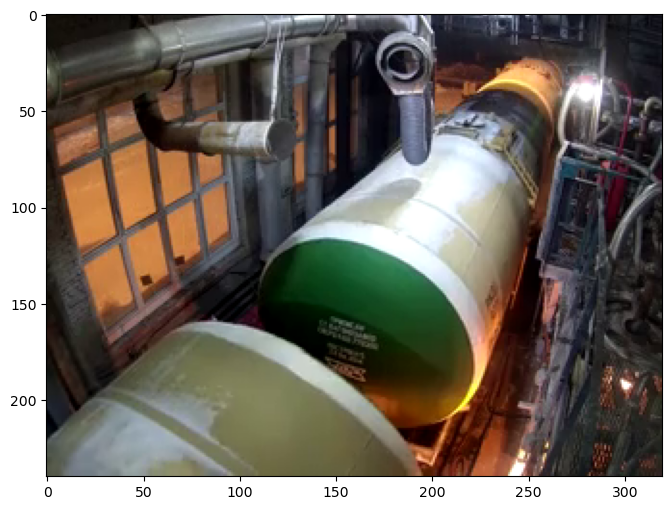

In [56]:
plt.figure(figsize=(8, 6))
plt.imshow(clip[2])
plt.grid(False)

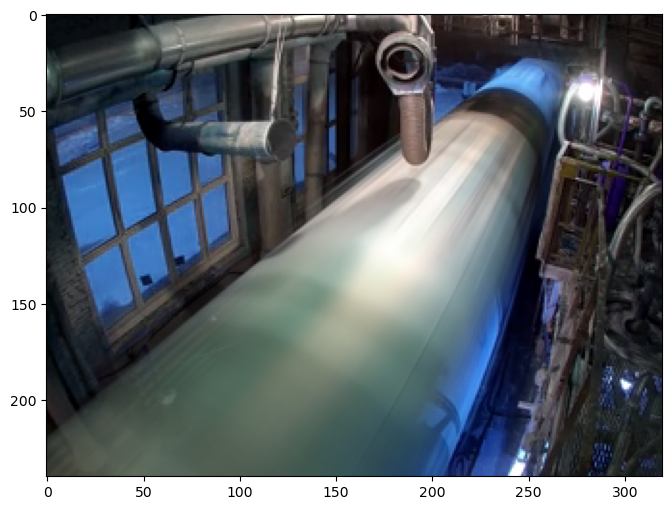

In [57]:
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(clip_avg, cv2.COLOR_BGR2RGB))
plt.grid(False)

# Model

In [80]:
# # Save averaged videos
# for _, row in train_clips.iterrows():
#     clip_path = DATA_DIR.joinpath('train', row['label'], row['fname'])
#     save_path = DATA_DIR.joinpath('train_avg', row['label'], row['fname'].replace('.mp4', '.jpg'))
#     clip_avg = avg_video(str(clip_path), mode='average', output_path=str(save_path))

In [81]:
label2id = {CLASSES[i]: i for i in range(len(CLASSES))}
id2label = {v: k for k, v in label2id.items()}

In [83]:
# with open('../output/submit_avg_video/id2label.pkl', 'wb') as fp:
#     pickle.dump(id2label, fp)

In [19]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((180, 180)),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [85]:
class AvgVideoDataset(Dataset):
    def __init__(self, 
                 data: pd.DataFrame,
                 transforms: Callable = None):
        self.data = data
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx: int):
        fname = self.data.iloc[idx]['fname']
        label_str = self.data.iloc[idx]['label']
        clip_avg_path = DATA_DIR.joinpath('train_avg', label_str, fname)
        clip_avg = torchvision.io.read_image(str(clip_avg_path))
        label = label2id[label_str]

        if self.transforms:
            clip_avg = self.transforms(
                clip_avg.numpy().transpose(1, 2, 0)
            )

        return clip_avg, label

In [86]:
train_data, val_data = train_test_split(train_clips_avg,
                                        train_size=0.8,
                                        stratify=train_clips['label'],
                                        shuffle=True,
                                        random_state=SEED)

In [87]:
train_data.shape, val_data.shape

((396, 2), (100, 2))

In [88]:
batch_size = 16

train_dataset = AvgVideoDataset(train_data, transforms=transforms)
val_dataset = AvgVideoDataset(val_data, transforms=transforms)


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

In [89]:
val_labels = val_data['label'].map(label2id)

In [90]:
freeze_pretrained = True
lr = 1e-4
weight_decay = 0.01

In [91]:
def construct_model() -> torch.nn.Module:
    model = mobilenet_v3_small(pretrained=True)

    for params in model.parameters():
        params.requires_grad = freeze_pretrained

    model.classifier[-1] = torch.nn.Linear(1024, len(CLASSES))

    return model

In [92]:
model = mobilenet_v3_small(pretrained=True)

for params in model.parameters():
    params.requires_grad = freeze_pretrained

model.classifier[-1] = torch.nn.Linear(1024, len(CLASSES))
model.to(DEVICE)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [93]:
# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=lr, 
                              weight_decay=weight_decay)

In [94]:
# Training loop
num_epochs = 5
for epoch in tqdm(range(num_epochs)):
    model.train()  # Set the model to training mode
    train_loss = 0.0

    for images, labels in tqdm(train_dataloader, desc='Training'):
        optimizer.zero_grad()

        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update statistics
        train_loss += loss.item()
        # predicted = outputs.argmax(1)

    train_loss /= len(train_dataloader)

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_preds = []
    with torch.inference_mode():
        for images, labels in tqdm(val_dataloader, desc='Validating'):
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Update statistics
            val_loss += loss.item()
            predicted = outputs.argmax(1)
            val_preds.extend(list(predicted.cpu().numpy()))

        val_f1 = f1_score(val_labels, val_preds, average='macro')

    val_loss /= len(val_dataloader)
    
    print(f'Epoch: {epoch}, Val F1: {val_f1}, Train loss: {train_loss}, Val loss: {val_loss}')


  0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 0, Val F1: 0.19135802469135801, Train loss: 0.9994884276390076, Val loss: 0.7943819335528782


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1, Val F1: 0.6143549702953728, Train loss: 0.6038623356819153, Val loss: 0.5203396890844617


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 2, Val F1: 0.9009324009324009, Train loss: 0.3960571610927582, Val loss: 0.2937439488513129


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 3, Val F1: 0.9409603409768681, Train loss: 0.2575370055437088, Val loss: 0.16163757230554307


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 4, Val F1: 0.9674745484400656, Train loss: 0.1541488140821457, Val loss: 0.09602995163628034


In [95]:
print(classification_report(val_labels, val_preds))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        62
           1       1.00      0.93      0.97        15
           2       0.91      1.00      0.95        10
           3       1.00      0.92      0.96        13

    accuracy                           0.98       100
   macro avg       0.97      0.96      0.97       100
weighted avg       0.98      0.98      0.98       100



In [97]:
model_save_path = '../output/submit_avg_video/mobilenet_v3_v1.pt'

In [98]:
torch.save(model.state_dict(), model_save_path)

# Inference

In [10]:
DEVICE = 'cpu'

In [23]:
model = construct_model()
with open('../output/submit_avg_video/mobilenet_v3.pkl', 'wb') as fp:
    pickle.dump(model, fp)

In [103]:
with open('../output/submit_avg_video/mobilenet_v3.pkl', 'rb') as fp:
    model_trained = pickle.load(fp)

model_trained.load_state_dict(torch.load(model_save_path, map_location=torch.device('cpu')))
model_trained.to(DEVICE);

In [104]:
model_trained.eval()  # Set the model to evaluation mode
val_preds = []
with torch.inference_mode():
    for images, labels in tqdm(val_dataloader, desc='Inference'):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Forward pass
        outputs = model_trained(images)

        # Update statistics
        predicted = outputs.argmax(1)
        val_preds.extend(list(predicted.cpu().numpy()))

Inference:   0%|          | 0/7 [00:00<?, ?it/s]

In [105]:
print(classification_report(val_labels, val_preds))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        62
           1       1.00      0.93      0.97        15
           2       0.91      1.00      0.95        10
           3       1.00      0.92      0.96        13

    accuracy                           0.98       100
   macro avg       0.97      0.96      0.97       100
weighted avg       0.98      0.98      0.98       100



In [11]:
sample_clip = train_clips.sample(100, random_state=SEED).iloc[50]
sample_clip_path = DATA_DIR.joinpath("train", sample_clip.label)
clip = read_clip(sample_clip_path, sample_clip.fname, transposed=False)

In [12]:
clip.shape

(256, 240, 320, 3)

In [13]:
type(clip)

numpy.ndarray

In [14]:
import cv2
import numpy as np


def avg_video(clip: np.ndarray,
              mode: str = 'average',
              max_frames: int = 1000,
              output_path: str = None) -> np.ndarray:
    num_frames = 0
    average_frame = None
    max_frame = None
    min_frame = None
    median_frame = None
    median_median_frame = None

    for frame in clip:
        if frame is None:
            break
        if mode == "median":
            if median_frame is None:
                median_frame = np.array([frame])
            else:
                median_frame = np.append(
                    median_frame, np.array([frame]), axis=0
                )
                if num_frames % 50 == 0:
                    if median_median_frame is None:
                        median_median_frame = np.array(
                            [np.median(median_frame, axis=0)]
                        )
                        median_frame = None
                    else:
                        median_median_frame = np.append(
                            median_median_frame,
                            np.array([np.median(median_frame, axis=0)]),
                            axis=0,
                        )
                        median_frame = None
        else:
            if average_frame is None:
                average_frame = frame.astype(float)
                max_frame = frame
                min_frame = frame
            else:
                average_frame += frame.astype(float)
                max_frame = np.maximum(frame, max_frame)
                min_frame = np.minimum(frame, min_frame)
        num_frames += 1
        if num_frames >= max_frames:
            break

    if mode == "average":
        average_frame /= num_frames
        average_frame = average_frame.astype("uint8")
        output_frame = average_frame
    elif mode == "max":
        output_frame = max_frame
    elif mode == "min":
        output_frame = min_frame
    else:
        if median_median_frame is None:
            median_median_frame = np.array([np.median(median_frame, axis=0)])
        elif num_frames % 50 > 25:
            median_median_frame = np.append(
                median_median_frame,
                np.array([np.median(median_frame, axis=0)]),
                axis=0,
            )
        median_median_frame = np.median(median_median_frame, axis=0)
        output_frame = median_median_frame

    output_frame = cv2.cvtColor(output_frame, cv2.COLOR_BGR2RGB)
    if output_path:
        cv2.imwrite(output_path, output_frame)

    return output_frame


In [15]:
clip_avg = avg_video(clip)
clip_avg.shape

(240, 320, 3)

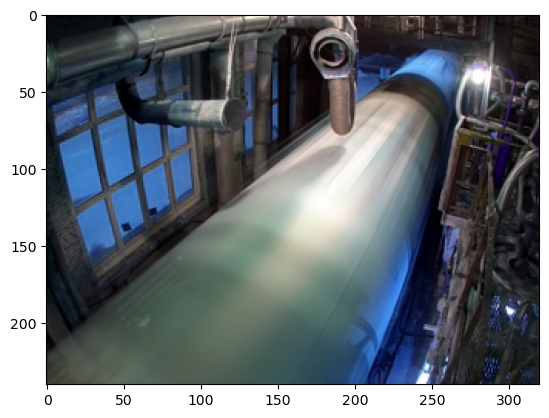

In [16]:
plt.imshow(clip_avg)

In [20]:
clip_avg = transforms(clip_avg)

In [21]:
clip_avg.shape

torch.Size([3, 180, 180])

In [22]:
clip_avg = clip_avg.unsqueeze(0)

In [23]:
clip_avg.shape

torch.Size([1, 3, 180, 180])